LOGISTIC on NATIVE DATASET

In [1]:

import multiprocessing
print(multiprocessing.cpu_count())

import psutil
print(f"Available memory before training: {psutil.virtual_memory().available / 1e9:.2f} GB")

12
Available memory before training: 8.91 GB


In [3]:

import numpy as np
import pandas as pd
pd.set_option('display.max_info_columns', 200)

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import pickle

In [5]:
token='p20'
study= pd.read_csv('C:\\Users\\lelan\\diabetic_data.csv')
print(study.shape)

(101766, 50)


In [7]:

study['target'] = study['readmitted'].isin(['>30', '<30']).astype(int)
study.drop(columns=['encounter_id', 'patient_nbr', 'readmitted'], inplace=True)

In [9]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.metrics import accuracy_score as sklearn_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc

In [49]:

X = study.drop(['target'], axis=1)
y = study['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

numeric_features = X.select_dtypes(include=['int64']).columns
object_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'), object_features)
    ])


In [51]:

%%time
logistic = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LogisticRegression(max_iter=1000))])

# Fit on training data
logistic.fit(X_train, y_train)
print('logistic fit on original data model fitting complete!')

# Save the trained model
with open(f"{token}_logistic__orig_data.pkl", "wb") as file:
    pickle.dump(logistic, file)
print(f"Model saved as {token}_logistic__orig_data.pkl")



logistic fit on original data model fitting complete!
Model saved as p20_logistic__orig_data.pkl
CPU times: total: 4.89 s
Wall time: 5.49 s


C:\Users\lelan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [5, 6, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\lelan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [5, 6, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\lelan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [5, 6, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fits data saved as fits_pickle_p20_logistic.pkl
Metrics saved to fits_pickle_p20_logistic.pkl
MSE (Train): 0.3527
MSE (Test): 0.3703
R-sq (Train): 0.6473
R-sq (Test): 0.6297
Accuracy: 0.6297
accuracy_score: 0.6297
Sensitivity: 0.5079
Specificity: 0.7342


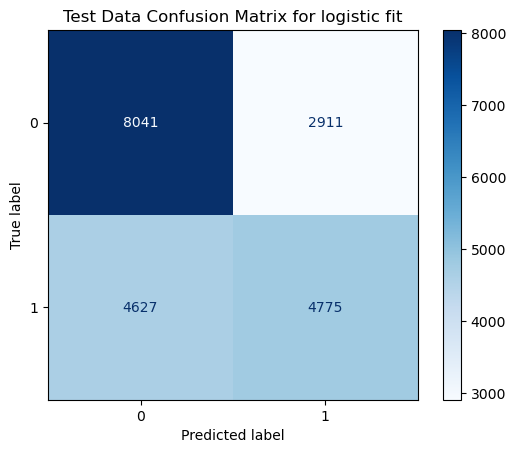

{'model_version': 'p20_logistic',
 'mse_train': 0.35266299808382057,
 'mse_test': 0.3703448953522649,
 'r2_train': 0.6473370019161794,
 'r2_test': 0.6296551046477351,
 'y_test': array([0, 0, 0, ..., 1, 1, 0]),
 'y_train_pred': array([0, 0, 0, ..., 0, 0, 0]),
 'y_test_pred': array([0, 0, 1, ..., 1, 0, 0]),
 'display_labels': array([0, 1]),
 'tn': 8041,
 'fp': 2911,
 'fn': 4627,
 'tp': 4775,
 'sensitivity': 0.5078706658157839,
 'specificity': 0.7342037983929875,
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99899562, 0.99899562,
        1.        ]),
 'tpr': array([0.00000000e+00, 1.06360349e-04, 5.31801744e-04, ...,
        9.99893640e-01, 1.00000000e+00, 1.00000000e+00]),
 'thresholds': array([       inf, 0.99934218, 0.99629197, ..., 0.05365364, 0.05243849,
        0.01122567]),
 'auc': 0.6739013748997967}

In [53]:

def evaluate_and_save_pipeline(pipeline, namestring, token, 
                               X_train, X_test, 
                               y_train, y_test):
    """
    Evaluates a trained pipeline and saves metrics to a pickle file.
    """

    # Properly check for missing inputs
    if any(v is None for v in [X_train, X_test, y_train, y_test]):
        raise ValueError("X_train, X_test, y_train, or y_test must not be None.")

    # Ensure data is in expected format (convert to numpy if necessary)
    y_train = y_train.values if hasattr(y_train, "values") else y_train
    y_test = y_test.values if hasattr(y_test, "values") else y_test

    # Make predictions
    y_test_pred = pipeline.predict(X_test)
    y_train_pred =  pipeline.predict(X_train)
    
    # Determine if model supports predict_proba or decision_function
    if hasattr(pipeline, "predict_proba"):
        y_test_pred_pct = pipeline.predict_proba(X_test)[:, 1]
    elif hasattr(pipeline, "decision_function"):
        y_test_pred_pct = pipeline.decision_function(X_test)
    else:
        raise AttributeError("🚨 This pipeline has neither predict_proba() nor decision_function(). Cannot generate continuous scores for ROC/AUC.")

    # Calculate metrics
    mse_train = mean_squared_error(y_train, pipeline.predict(X_train))
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = pipeline.score(X_train, y_train)
    r2_test = pipeline.score(X_test, y_test)

    # Confusion matrix & sensitivity/specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    accuracy = (tn+tp)/ (tn+tp+fn+fp)
    accuracy_score = sklearn_accuracy_score(y_test, y_test_pred) 
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_pct)
    roc_auc = auc(fpr, tpr)

    # Save metrics
    pickle_metrics = {
        'model_version': f"{token}_{namestring}",
        'mse_train': mse_train,
        'mse_test': mse_test,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'y_test': y_test,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'display_labels': pipeline.classes_ ,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'auc': roc_auc
    }
    
    filename = f"fits_pickle_{token}_{namestring}.pkl"
    with open(filename, "wb") as file:
        pickle.dump(pickle_metrics, file)
    print(f"Fits data saved as {filename}")

    # Print summary
    print(f"Metrics saved to {filename}")
    print('MSE (Train):',  round(mse_train,4))
    print('MSE (Test):',   round(mse_test, 4))
    print('R-sq (Train):', round(r2_train, 4))
    print('R-sq (Test):',  round(r2_test,  4))
    print('Accuracy:', round(accuracy, 4))
    print('accuracy_score:', round(accuracy_score,4))
    print('Sensitivity:', round(sensitivity,4))
    print('Specificity:', round(specificity,4))
    

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Test Data Confusion Matrix for {namestring} fit")
    plt.show()

    return pickle_metrics

# Example function call
evaluate_and_save_pipeline(
    pipeline=logistic,
    namestring='logistic',
    token=token, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test
)

#expect warnings due to rare dx codes not observed equally in test and train

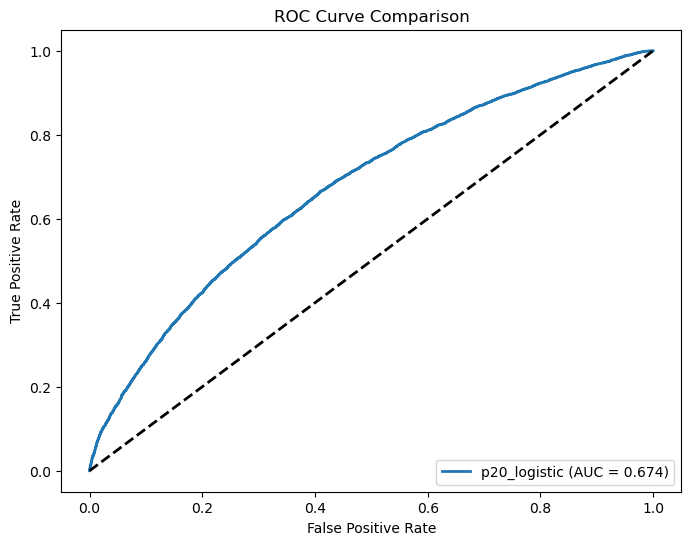

In [55]:

fits_pickles =['fits_pickle_p20_logistic.pkl' ]

colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#bcbd22',  # lime
    '#17becf',  # cyan
    '#393b79',  # dark blue
    '#637939'   # dark green
]


def plot_roc_curves(fits_pickles):
    plt.figure(figsize=(8, 6))
    
    for i, file in enumerate(fits_pickles):
        model_data = pd.read_pickle(file)
        plt.plot(model_data['fpr'], model_data['tpr'], color=colors[i % len(colors)], lw=2, 
                 label=f"{model_data['model_version']} (AUC = {model_data['auc']:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
# plot_roc_curves(['lasso_metrics.pkl', 'ridge_metrics.pkl'])
plot_roc_curves(fits_pickles)